<a href="https://colab.research.google.com/github/cc4351/teamtracking/blob/Chen/0613_Chen_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

This is a summary note on the progress I've made on the particle side, and will include the followings:
- part1: the modifications I've made on Matlab scripts [DONE]
- part2: a commented python script to organze particle- and track- level data into a defaultdict [DONE]
- part3: data analysis on pValue [DONE]
- part4: my attempts to incorporate pValues with track-level features, this part does not yield particularly meaningful data, but the code blocks might be useful for other purposes and therefore are included here as well. 

In [0]:
# import packages 
# --> run this cell if you plan to run any parts other than part1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import statistics
import math
from time import time
import os
from collections import defaultdict
import pickle
import plotly.express as px
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN

# Part 1 Matlab Modifications

**Part 1 Matlab Modifications**
- for the complete scripts that have been modified: https://github.com/cc4351/teamtracking/tree/Chen/Matlab%20Modification
- in detectSubResFeatures2D_V2.m
```
% line 238 --> added a field 'pValue'
    clustersMMF = repmat(struct('position',[],'amplitude',[],'bgAmp',[],...
        'numDegFree',[],'residuals',[],'sigma',[], 'pValue', []),numClusters,1)
% line 433, 514 --> added the pValue into clustersMMF
    clustersMMF(i).pValue = pValue;
% line 756-762 --> save the value in keepCluster
    if pValue < alphaF
        keepCluster(iCluster) = 0;
    else
        keepCluster(iCluster) = pValue;
    end
% line 780 --> save pValue in detectedFeatures
    detectedFeatures.pValue = vertcat(clustersMMF.pValue); 
```
- in detectSubResFeatures2D_StandAlone.m
```
% line 499-500 --> added a field to cands
    movieInfo = repmat(struct('xCoord',[],'yCoord',[],'amp',[],'sigma',[], 'pValue', []),numImagesRaw,1);
```


# Part 2 Python Script to Reorganize the Data Structure

In [0]:
# load data
# ref: https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC
# note that all the data could be found at https://github.com/cc4351/teamtracking/tree/Chen/data

# REMEMBER TO MOUNT YOUR GOOGLE DRIVE AND CHANGE FILE PATHS BEFORE RUNNING THIS CELL

# load tracksFinal.mat
tracksFinal = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/tracksFinal.mat')['tracksFinal'] #<=replace the path
coordAmp = tracksFinal['tracksCoordAmpCG']
tracksIdx = tracksFinal['tracksFeatIndxCG']
seqOfEvents = tracksFinal['seqOfEvents']
# trackStartFrameIndex
myTrackStart = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/trackStart.mat')['trackStart'] #<=replace the path
# movieInfo with pValues
movieInfo = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/new_movieInfo.mat')['movieInfo'] #<=replace the path
xCoord = movieInfo['xCoord']
yCoord = movieInfo['yCoord']
ampCoord = movieInfo['amp']
pValues = movieInfo['pValue']

In [0]:
# for frame_particles: 
# the key is the global frame index, 
# the value is the x, y, amp, and pValue of each particles detected at each frame

numFrame = len(xCoord)
frame_particles = defaultdict(list)
for i in range(numFrame):
    xCo = xCoord[i][0][:, 0]
    yCo = yCoord[i][0][:, 0]
    amps = ampCoord[i][0][:, 0]
    pVal = pValues[i][0]
    numSpot = len(xCo)
    li = np.column_stack((xCo, yCo, amps, pVal))
    frame_particles[i] = li

In [0]:
# save data into defaultdict tracks

# track object: ['length', 'particles', 'track_start', 'track_end']
# particle object: ['x', 'y', 'amp', 'x-std', 'y-std', 'amp-std', 'frame', 'frame_index', 'pValue']
# particle[trackId]-->dictionary of dictionaries
# note that everything starts from 0 in Python, so the frameId, trackId, and the particleId should be (NumInMatlab-1) 

particles = defaultdict(dict)
tracks = defaultdict(dict)

"""
For every frame, the matrix stores
the particle’s x-coordinate, y-coordinate, z-coordinate (0 if 2D),amplitude, x-coordinate standard deviation, ycoordinate
standard deviation, z-coordinate standard deviation (0 if 2D) and amplitude standard deviation.
"""
for i in enumerate(coordAmp):
    content = i[1][0][0]
    tracks[i[0]]['length'] = len(content)//8
    tmp = list()
    per = dict()
    for j in enumerate(content):
        idx = j[0]
        item = j[1]
        if idx%8 == 0:
            if per!={}:
                tmp.append(per)
            per = dict()
            per['x'] = item
        elif idx%8 == 1:
            per['y'] = item
        elif idx%8 == 3:
            per['amp'] = item
        elif idx%8 == 4:
            per['x-std'] = item
        elif idx%8 == 5:
            per['y-std'] = item
        elif idx%8 == 7:
            per['amp-std'] = item
    tmp.append(per)
    tracks[i[0]]['particles'] = tmp

In [0]:
# step-1 find the global frame index for each particle
for i in enumerate(myTrackStart):
    idx = i[0]
    sequence = i[1][0]
    tracks[idx]['track_start'] = sequence
    tracks[idx]['track_end'] = sequence + tracks[idx]['length']-1
    tr = tracks[idx]
    for j in enumerate(tr['particles']):
        count = j[0]
        j[1]['frame'] = sequence+count

In [0]:
# step-2 find the particle index local to each frame
# tracksIdx = tracksFinal['tracksFeatIndxCG']
for i in enumerate(tracksIdx):
    idx = i[0]
    sequence = i[1][0][0]
    tr = tracks[idx]
    for j in enumerate(tr['particles']):
        count = j[0]
        j[1]['frame_index'] = sequence[count]

In [0]:
# step-3 find the corresponding p-values
for k, v in tracks.items():
    for j in v['particles']:
        frame = j['frame']-1
        idx = j['frame_index']-1
        val = pValues[frame][0][idx][0]
        j['pValue'] = val

In [0]:
tracks[0]['particles'][-1]

{'amp': 0.0005410485793569974,
 'amp-std': 5.479991328460485e-05,
 'frame': 1354,
 'frame_index': 8,
 'pValue': 2.7620687702567537e-06,
 'x': 68.10772549184743,
 'x-std': 0.15274471488255942,
 'y': 125.76983235393375,
 'y-std': 0.15273932675794977}

In [0]:
# save the structure into a designated folder
# ref: https://www.saltycrane.com/blog/2008/01/saving-python-dict-to-file-using-pickle/
while tracks[len(tracks)-1] == {}:
    del tracks[len(tracks)-1]
output = open('/content/drive/My Drive/Colab Notebooks/Molecule/tracks', 'wb')
pickle.dump(tracks, output)
output.close()

# Part 3 Data Analysis on pValue

In [0]:
# if part2 is not run beforehand and the tracks data is available in google drive
# run this cell
pkl_file = open('/content/drive/My Drive/Colab Notebooks/Molecule/tracks', 'rb')
tracks = pickle.load(pkl_file)
pkl_file.close()

In [0]:
pAvgs = [] # for mean of pValue
pStds = [] # for std of pValue
pLengths = [] # for trackLength

for item in tracks.values():
    pLengths.append(item['length'])
    pList = []
    for pt in item['particles']:
        pList.append(pt['pValue'])
    pAvgs.append(statistics.mean(pList))
    pStds.append(statistics.pstdev(pList))

In [0]:
# a graphying function written in plotly.express
def pxGraph(title, xAxis, yAxis, X, Y):
    fig = px.scatter(x=X, y=Y)
    fig.update_layout(
        autosize=False,
        width=500,height=375,
        title={'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title=yAxis,
        xaxis_title=xAxis,
        font=dict(
            # family="Courier New, monospace",
            size=15,
            color="#7f7f7f"
        )
    )
    return fig

In [81]:
# # good old matplotlib --> run this to get a small image
# plt.plot(pAvgs, pLengths, 'x')  
# plt.title('trackLength - meanPValue')
# plt.xlabel('mean pValue')
# plt.ylabel('trackLength')

# for better UX
pxGraph('trackLength - meanPValue', 'mean pValue', 'trackLength', pAvgs, pLengths).show()

In [82]:
# # good old matplotlib --> run this to get a small image
# plt.plot(np.log(pAvgs), np.log(pLengths), 'x')  
# plt.title('log trackLength - log AvgPValue')
# plt.xlabel('log of mean pValue')
# plt.ylabel('log of trackLength')

# for better UX
pxGraph('log trackLength - log AvgPValue', 'log of mean pValue', 'log of trackLength', np.log(pAvgs), np.log(pLengths)).show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log



In [83]:
# good old matplotlib --> run this to get a small image
# plt.plot(pStds, pLengths, 'x')  
# plt.title('trackLength - stdPValue')
# plt.xlabel('pValue std')
# plt.ylabel('trackLength')

# for better UX
pxGraph("trackLength - stdPValue", "pValue std", "trackLength", pStds, pLengths).show()

In [84]:
# # good old matplotlib --> run this to get a small image
# plt.plot(np.log(pStds), np.log(pLengths), 'x')  
# plt.title('log trackLength - log stdPValue')
# plt.xlabel('log of pValue std')
# plt.ylabel('log of trackLength')

# for better UX
pxGraph('log trackLength - log stdPValue', 'log of pValue std', 'log of trackLength', np.log(pStds), np.log(pLengths)).show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log



In [85]:
# longest single track: the change of pValue over a track
trackId = 0
item = tracks[trackId]
pList = []
for pt in item['particles']:
    pList.append([pt['frame'], pt['pValue']])
pList = np.asarray(pList)
# good old matplotlib --> run this to get a small image
# plt.plot(pList[:, 0], pList[:, 1], 'x')
# plt.title('track 1 - pValue variation')

# for better UX
pxGraph('track 1 - pValue variation', "frame number", "pValue", pList[:, 0], pList[:, 1]).show()

In [86]:
# one of the shortest single track: the change of pValue over a track
trackId = len(tracks)-1
item = tracks[trackId]
pList = []
for pt in item['particles']:
    pList.append([pt['frame'], pt['pValue']])
pList = np.asarray(pList)
# # good old matplotlib --> run this to get a small image
# plt.plot(pList[:, 0], pList[:, 1], 'x')
# plt.title('last track - pValue variation')

# for better UX
pxGraph('last track - pValue variation', "frame number", "pValue", pList[:, 0], pList[:, 1]).show()

# Part 4 T-SNE and DBSCAN with pValue Incorporated

In [0]:
# if part2 is not run beforehand and the tracks data is available in google drive
# run this cell
pkl_file = open('/content/drive/My Drive/Colab Notebooks/Molecule/tracks', 'rb')
tracks = pickle.load(pkl_file)
pkl_file.close()

In [0]:
# modified manalanobis TSNE (the default sklearn version doesn't work)
import scipy.sparse as sp
from sklearn.manifold import TSNE
from sklearn.externals.six import string_types
from sklearn.utils import check_array, check_random_state
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold._t_sne import _joint_probabilities, _joint_probabilities_nn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy import sparse

class MyTSNE(TSNE):
    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean", metric_params=None, #<=ADDED
                 init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.metric_params = metric_params  #<=ADDED
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle

    def _fit(self, X, skip_num_points=0):
        # error raising, see src code @ https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/_t_sne.py
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.metric == "precomputed":
            if isinstance(self.init, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if np.any(X < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
        # about Barnes-Hut Octatree: https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation
        if self.method == 'barnes_hut' and sp.issparse(X):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        if self.n_iter < 250:
            raise ValueError("n_iter should be at least 250")
        
        n_samples = X.shape[0]

        neighbors_nn = None
        # if method == 'exact', if not specified, the method would be barnes-nout by default
        if self.method == "exact":
            if self.metric == "precomputed":
                distances = X
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances = pairwise_distances(X, metric=self.metric,
                                                   squared=True,
                                                   **self.metric_params) #<=ADDED
                else:
                    distances = pairwise_distances(X, metric=self.metric,
                                                   **self.metric_params) #<=ADDED

                if np.any(distances < 0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")

            P = _joint_probabilities(distances, self.perplexity, self.verbose)
            assert np.all(np.isfinite(P)), "All probabilities should be finite"
            assert np.all(P >= 0), "All probabilities should be non-negative"
            assert np.all(P <= 1), ("All probabilities should be less "
                                    "or then equal to one")

        # for methods other than 'exact'
        else:
            k = min(n_samples - 1, int(3. * self.perplexity + 1))

            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors...".format(k))
            
            # print("been here")
            knn = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric, 
                                   metric_params = self.metric_params) #<=ADDED
            # print("done that")
            t0 = time()
            knn.fit(X)
            print("fit well")
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn, neighbors_nn = knn.kneighbors(
                None, n_neighbors=k)
            duration = time() - t0
        
            nnb = distances_nn.shape[1]
            comb = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(nnb):
                    idx = neighbors_nn[i][j]
                    ds = distances_nn[i][j]
                    comb[i][idx] = ds
            comb = sparse.csr_matrix(comb)
            # ref: https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix


            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                      .format(n_samples, duration))

            del knn

            if self.metric == "euclidean":
                distances_nn **= 2
            
            # ref: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/_t_sne.py
            P = _joint_probabilities_nn(comb,
                                        self.perplexity, self.verbose)

        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init == 'random':
            X_embedded = 1e-4 * random_state.randn(
                n_samples, self.n_components).astype(np.float32)
        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        degrees_of_freedom = max(self.n_components - 1.0, 1)

        return self._tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)

In [0]:
# tsne-dbscan procedure --> in an attempt to replicate Cynthia's result
def tsne_dbscan(X, title):
    tsne = MyTSNE(verbose=1,perplexity=40,n_iter=7000,learning_rate=50, random_state=0,
        metric='mahalanobis', metric_params={'V': np.cov(X, rowvar=False)})
    X_embedded = TSNE(n_components=2).fit_transform(X)
    labels = DBSCAN(eps=5, min_samples=10).fit_predict(X_embedded)
    # colorscale ref: https://matplotlib.org/examples/color/colormaps_reference.html
    fig = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=10)
    plt.winter()
    plt.title(title)
    return fig

In [0]:
# ref: https://stackoverflow.com/a/21032099/12144813
def normalized(X, axis=1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2==0] = 1
    return X / np.expand_dims(l2, axis)

In [0]:
# pre-processing of tracks --> mean, min, max of the amplitude, and the std of pValue as 4 features to use
# the particular features are chosen based on previous trial and error, and other features could be extracted
# from the tracks structure through modifications of the for loop
for tr in tracks.values():
    amps = []
    pVs = []
    for pt in tr['particles']:
        # skipped the NaN value of amp
        if(np.isnan(pt['amp']) == False): 
            amps.append(pt['amp'])
        if(np.isnan(pt['pValue']) == False):
            pVs.append(pt['pValue'])
    tr['meanAmp'] = statistics.mean(amps)
    tr['minAmp'] = min(amps)
    tr['maxAmp'] = max(amps)
    tr['pValueStd'] = statistics.pstdev(pVs)

In [0]:
# extracting features --> this part could be modified to extract other features 
minA = [tr['minAmp'] for tr in tracks.values()]
maxA = [tr['maxAmp'] for tr in tracks.values()]
meanA = [tr['meanAmp'] for tr in tracks.values()]
pVstd = [tr['pValueStd'] for tr in tracks.values()]
trackL = [tr['length'] for tr in tracks.values()]

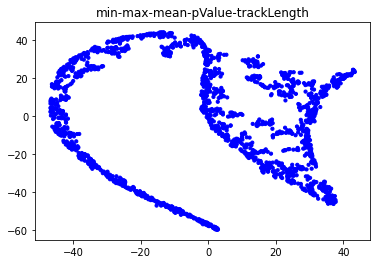

In [113]:
X = np.column_stack((minA, maxA, meanA, pVstd, trackL))
X = normalize(X)
tol = 1e-5
assert abs(sum(X[0])-1) < tol
tsne_dbscan(X, "min-max-mean-pValue-trackLength")

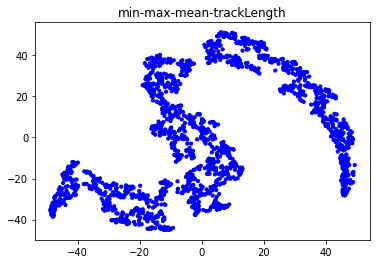

In [115]:
X = np.column_stack((minA, maxA, meanA, trackL))
X = normalize(X)
tol = 1e-5
assert abs(sum(X[0])-1) < tol
tsne_dbscan(X, "min-max-mean-trackLength")

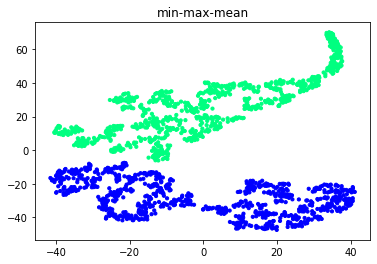

In [139]:
X = np.column_stack((minA, maxA, meanA))
X = normalize(X)
tsne_dbscan(X, "min-max-mean")